In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import time

W0412 12:06:59.415207 140154719172416 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
#module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
#module_url = "/home/mallik/Documents/DataScience/projects/nlp/sentence_similarity/sentence_encoder/universal-sentence-encoder-2"
module_url = "../3_large"

embed = hub.Module(module_url,trainable=True)

In [3]:
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  print(corr)
  sns.set(font_scale=1.2)
  g = sns.heatmap(corr,xticklabels=labels,yticklabels=labels,vmin=0,vmax=1,cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
  message_embeddings_ = session_.run(
      encoding_tensor, feed_dict={input_tensor_: messages_})
  plot_similarity(messages_, message_embeddings_, 90)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0412 12:11:16.447555 140154719172416 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


[[1.0000002 0.8629419]
 [0.8629419 1.       ]]
2.086590528488159


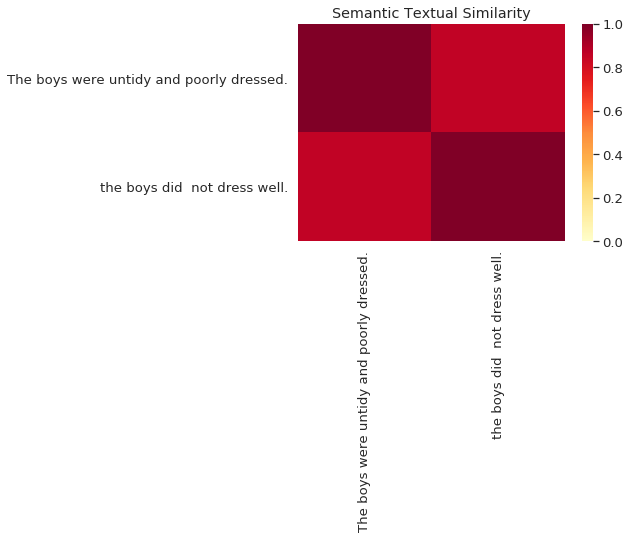

In [4]:
#to test similarity of few sentences
messages = [
    "The boys were untidy and poorly dressed.",
    "the boys did  not dress well."
]

similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)

with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  s_t=time.time()  
  run_and_plot(session, similarity_input_placeholder, messages,
               similarity_message_encodings)
  e_t=time.time() 
  print(e_t - s_t)

In [5]:
hidden_units_2 = 50
hidden_units_3 = 10
num_classes = 3
learning_rate = 0.01
batch_size = 8
training_epochs = 5

In [6]:
X=tf.placeholder(tf.string,[None,2])
Y = tf.placeholder("float", [None, num_classes])

In [7]:
def network(input_values):
    layer1_s1=embed(input_values[:,0])
    layer1_s2=embed(input_values[:,1])
    layer1 = tf.concat([layer1_s1,layer1_s2],axis=1)
    
    layer2 = tf.layers.dense(inputs=layer1,units=hidden_units_2,activation=tf.nn.relu)
    
    layer3 = tf.layers.dense(inputs=layer2,units=hidden_units_3,activation=tf.nn.relu)
    
    layer4 = tf.layers.dense(inputs=layer3,units=num_classes,activation=tf.nn.relu)
    
    return layer4
    

In [8]:
logits = network(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
# Initializing the variables
init = tf.global_variables_initializer()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0412 12:11:42.855066 140154719172416 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0412 12:11:44.058573 140154719172416 tf_logging.py:115] Saver not created because there are no variables in the graph to restore


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



W0412 12:11:44.533178 140154719172416 tf_logging.py:125] From <ipython-input-8-d22dd7ffaccc>:5: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

/home/mallik/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [9]:
tr_data = pd.read_csv("../data/new_train_data.csv")

In [19]:
tr_data.shape

(550152, 4)

In [20]:
#training on a very small corpus for verifying the working of network
x_data = tr_data[['sent1','sent2']][0:100]
y_data = pd.DataFrame({'1_similar':tr_data['label'][0:100],'2_neutral':tr_data['label'][0:100],'3_opposite':tr_data['label'][0:100]})
#x_data
y_data['1_similar']=y_data['1_similar'].replace({1:1,2:0,3:0})
y_data['2_neutral']=y_data['2_neutral'].replace({1:0,2:1,3:0})
y_data['3_opposite']=y_data['3_opposite'].replace({1:0,2:0,3:1})
#y_data

In [21]:
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(len(x_data)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x = x_data[i*batch_size:(i+1)*batch_size]
            batch_y = y_data[i*batch_size:(i+1)*batch_size]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([train_op, loss_op], feed_dict={X: batch_x,
                                                            Y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch

        print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avg_cost))
    print("Optimization Finished!")

    # Test model
    pred = tf.nn.softmax(logits)  # Apply softmax to logits
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({X: x_data, Y: y_data}))

FailedPreconditionError: Table not initialized.
	 [[Node: module_apply_default_2/text_preprocessor/string_to_index_Lookup/hash_table_Lookup = LookupTableFindV2[Tin=DT_STRING, Tout=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](module/text_preprocessor/string_to_index/hash_table, module_apply_default_2/text_preprocessor/GatherNd, module_apply_default_1/text_preprocessor/string_to_index/hash_table/Const)]]

Caused by op 'module_apply_default_2/text_preprocessor/string_to_index_Lookup/hash_table_Lookup', defined at:
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-d22dd7ffaccc>", line 1, in <module>
    logits = network(X)
  File "<ipython-input-7-7a99efb0c1b0>", line 3, in network
    layer1_s2=embed(input_values[1])
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tensorflow_hub/module.py", line 250, in __call__
    name=name)
  File "/home/mallik/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/tensorflow_hub/native_module.py", line 517, in create_apply_graph
    import_scope=relative_scope_name)
  File "/home/mallik/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1939, in import_meta_graph
    **kwargs)
  File "/home/mallik/.local/lib/python3.6/site-packages/tensorflow/python/framework/meta_graph.py", line 744, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "/home/mallik/.local/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/home/mallik/.local/lib/python3.6/site-packages/tensorflow/python/framework/importer.py", line 442, in import_graph_def
    _ProcessNewOps(graph)
  File "/home/mallik/.local/lib/python3.6/site-packages/tensorflow/python/framework/importer.py", line 234, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "/home/mallik/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3289, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "/home/mallik/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3289, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "/home/mallik/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3180, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "/home/mallik/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Table not initialized.
	 [[Node: module_apply_default_2/text_preprocessor/string_to_index_Lookup/hash_table_Lookup = LookupTableFindV2[Tin=DT_STRING, Tout=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](module/text_preprocessor/string_to_index/hash_table, module_apply_default_2/text_preprocessor/GatherNd, module_apply_default_1/text_preprocessor/string_to_index/hash_table/Const)]]
